![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [131]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [4]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

Como podemos en los resultados anteriores, **la temporada en la cual se rentan mas bicicletas es en verano (3), mientras que aquella en la que menos se rentan es invierno (1)**. Esto hace sentido si tenemos en cuenta las condiciones climaticas que pueden dificultar o en su defecto facilitar montar bicicleta o preferir otros medios de transporte.

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

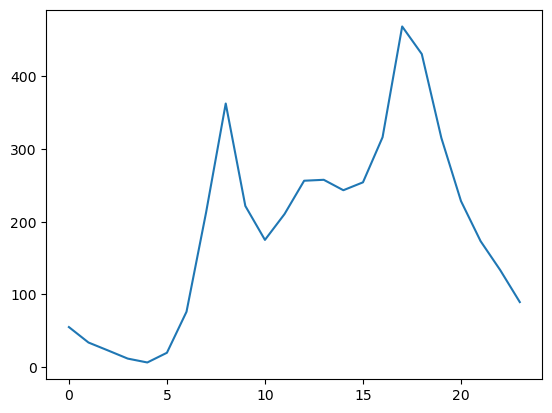

In [15]:
# Gráfico de líneas
fig, ax = plt.subplots()
ax.plot(bikes.groupby('hour').total.mean())
plt.show()

Vemos que en horas de la madrugada hay un volumen muy bajo de alquiler de bicicletas, claramente por la baja actividad de clientes en este horario. Vemos que hay dos picos importantes, el primero a las 8am y el segundo a alrededor de las 5pm, los cuales concuerdan con los horarios en las cuales las personas suelen transportarse hacia su trabajo y a su hogar respectivamente.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

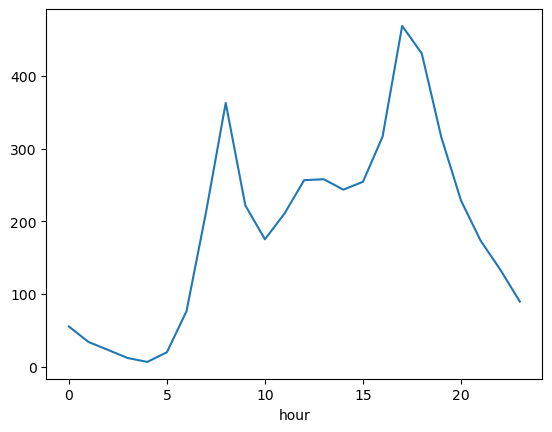

In [16]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

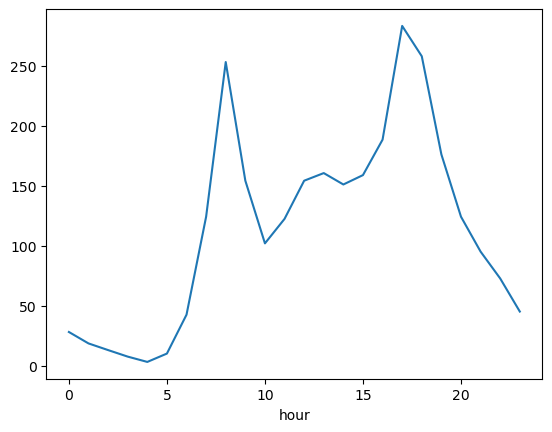

In [19]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 
bikes_winter = bikes.loc[bikes['season'] == 1]
bikes_winter.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

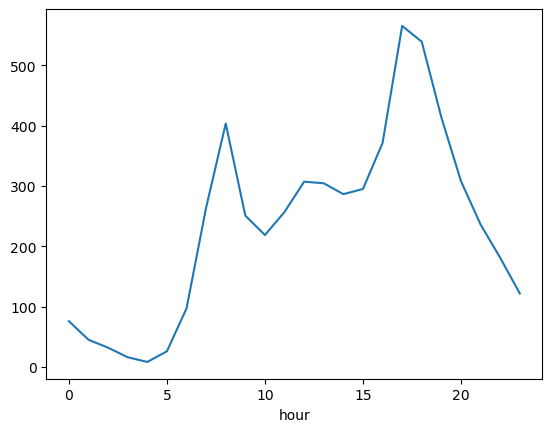

In [21]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes_summer = bikes.loc[bikes['season'] == 3]
bikes_summer.groupby('hour').total.mean().plot()

Si comparamos los resultados entre las dos temporadas, vemos que el comportamiento a lo largo del dia es igual independientemente de la temporada pero, el promedio de alquileres es mucho mayor durante el verano.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [25]:
# Celda 3
# datos de ejemplo
X = bikes[['season', 'hour']]
y = bikes[['total']]

# crear el modelo de regresión lineal
model = LinearRegression()

# ajustar el modelo a los datos
model.fit(X, y)

# hacer predicciones
y_pred = model.predict(X)

# imprimir los coeficientes y el error cuadrático medio
print("Coeficientes: ", model.coef_)
print("Intercepto: ", model.intercept_)
print("Error cuadrático medio: ", np.mean((y_pred - y) ** 2))

Coeficientes:  [[26.95130851 10.52129824]]
Intercepto:  [2.58485133]
Error cuadrático medio:  total    26640.032545
dtype: float64


El problema que tenemos con este modelo es que es poco interpretable. Vemos que el coefeiciente para la temporada es 26.95 y para la hora es 10.52, es decir que por cada unidad adicional en estas variables nuestra respuesta en el total va a aumentar en esas dimensiones respectivamente. Pero, de nuevo, es dificil interpretar lo que hace el modelo

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [45]:
# Celda 4
# Traemos el codigo de arbol manual usado en los talleres del curso 
#Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split
# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [44]:
X = bikes[['season', 'hour']]
y = bikes[['total']]

tree_grow(X, y, level=0, min_gain=0.001, max_depth=3, num_pct=10)

{'y_pred': 1,
 'y_prob': total    191.539034
 dtype: float64,
 'level': 0,
 'split': -1,
 'n_samples': 10886,
 'gain': total    1015.000291
 dtype: float64}

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [46]:
# Celda 5
# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)

# Lista para guardar los valores del RMSE para cada valor de máxima profundidad (max_depth)
accuracy_scores = []

# Importación de modelos de sklearn 
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

# Loop para obtener el desempeño del modelo de acuerdo con la máxima profundidad
for depth in max_depth_range:
    # Definición del árbol de decisión usando DecisionTreeClassifier de la libreria sklearn
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0, 0.5, 'Accuracy')

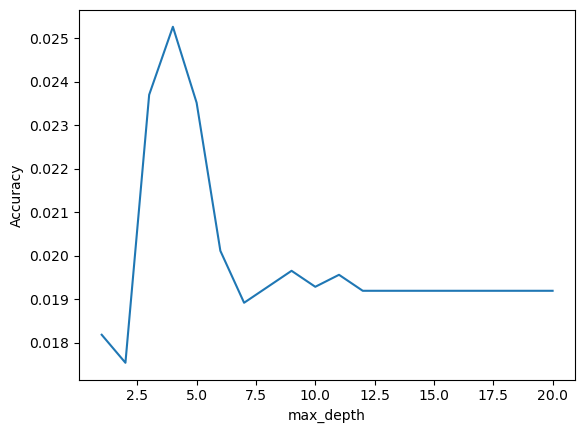

In [47]:
# Gráfica max_depth versus RMSE (error del modelo)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [48]:
# Mejor accuracy (desempeño del modelo) y su correspondiente max_depth
sorted(zip(accuracy_scores, max_depth_range))[::-1][0]

(0.025261134067952253, 4)

In [51]:
# max_depth=4 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeClassifier(max_depth=4, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=1)

In [55]:
# Predecir los valores de la variable objetivo para los datos de entrenamiento
y_pred = clf.predict(X_test)

# Calcular el MSE
mse = mean_squared_error(y_test, y_pred)

print('MSE:', mse)

MSE: 19969.020514390693


Si comparamos el MSE del arbol de decision y el del modelo lineal, vemos que **el arbol de decision es mejor con un MSE de 19,969**. Esto posiblemente se debe a que estamos haciendo de variables categoricas y el arbol tiene la propiedad de poder trabajar con estas.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [134]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [135]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [136]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [137]:
# Celda 6
# Vamos a usar el mismo arbol que creamos enteriormente, el cual ya tiene calibrado el parametro de la profundidad
models = {'lr': LogisticRegression(),
          'dt': clf}

In [138]:
# Entrenamiento (fit) de cada modelo
for model in models.keys():
    models[model].fit(X_train, y_train)

In [139]:
# Predicción de las observaciones del set de test para cada modelo
y_pred = pd.DataFrame(index=y_test.index, columns=models.keys())
for model in models.keys():
    y_pred[model] = models[model].predict(X_test)

In [140]:
y_pred

,lr,dt
1483,1,1
2185,0,1
2520,1,1
3721,1,1
3727,0,0
...,...,...
3077,0,1
5166,0,0
2227,0,1
5684,0,0


In [141]:
# Evaluación del error de cada modelo
from sklearn.metrics import mean_squared_error

for model in models.keys():
    print(model,np.sqrt(mean_squared_error(y_pred[model], y_test)))

lr 0.6212889826803627
dt 0.589915248150105


In [142]:
# Evaluación  del error promedio de las predicciones
np.sqrt(mean_squared_error(y_pred.mean(axis=1), y_test))

0.5512107884769069

In [143]:
# Calcular la precisión del modelo
for model in models.keys():
    print(f"Modelo {model}")
    accuracy = accuracy_score(y_test, y_pred[model])
    print('Precisión:', accuracy)

    # Calcular el puntaje F1 del modelo
    f1 = f1_score(y_test, y_pred[model])
    print('Puntaje F1:', f1)

Modelo lr
Precisión: 0.614
Puntaje F1: 0.6106254203093476
Modelo dt
Precisión: 0.652
Puntaje F1: 0.6552179656538969


**Vemos que en este caso los dos modelos tienen un comportamiento muy similar, siendo el modelo de arbol de decision
ligeramente mejor con base en el F1-Score**


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth tome un valor de su elección\
-100 árboles de decisión donde min_samples_leaf tome un valor de su elección\
-100 regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

In [144]:
# Celda 7
# 100 arboles con libre max_depth 
# Definición del modelo BaggingClassifier de la libreria sklearn
tree1 = DecisionTreeClassifier(max_depth = 3)
tree2 = DecisionTreeClassifier(min_samples_leaf = 6)
from sklearn.ensemble import BaggingClassifier
clf1 = BaggingClassifier(base_estimator=tree1, n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf2 = BaggingClassifier(base_estimator=tree2, n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf3 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)


In [145]:
# Predicción y desempeño al hacer votación mayoritaria
from sklearn import metrics
clf1.fit(X_train, y_train)
y_pred1 = clf1.predict(X_test)
metrics.f1_score(y_pred1, y_test), metrics.accuracy_score(y_pred1, y_test)

(0.6376614547926581, 0.6446666666666667)

In [146]:
from sklearn import metrics
clf2.fit(X_train, y_train)
y_pred2 = clf2.predict(X_test)
metrics.f1_score(y_pred2, y_test), metrics.accuracy_score(y_pred2, y_test)

(0.6552179656538969, 0.652)

In [147]:
from sklearn import metrics
clf3.fit(X_train, y_train)
y_pred3 = clf3.predict(X_test)
metrics.f1_score(y_pred3, y_test), metrics.accuracy_score(y_pred3, y_test)

/Users/tomasvargas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tomasvargas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

(0.6140350877192983, 0.6186666666666667)

**Al comparar los tres escenarios, vemos que el conjunto de los 100 arboles con profundidad libre y minimo 6 hojas tiene el mejor comportamiento con base en el F1-Score**

### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [156]:
# Celda 8
tree1 = DecisionTreeClassifier(max_depth = 3)
tree2 = DecisionTreeClassifier(min_samples_leaf = 6)
from sklearn.ensemble import BaggingClassifier
clf1 = BaggingClassifier(base_estimator=tree1, n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf2 = BaggingClassifier(base_estimator=tree2, n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)
clf3 = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100, bootstrap=True,
                        random_state=42, n_jobs=-1, oob_score=True)

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)
clf3.fit(X_train, y_train)

/Users/tomasvargas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/tomasvargas/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100,
                  n_jobs=-1, oob_score=True, random_state=42)

In [157]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf1.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf1.n_estimators))

for i in range(clf1.n_estimators):
    oob_sample = ~clf1.estimators_samples_[i]
    y_pred_ = clf1.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf1.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

print("Resultados del escenario 1")
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

Resultados del escenario 1


(0.638153428377461, 0.6446666666666667)

In [158]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf2.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf2.n_estimators))

for i in range(clf2.n_estimators):
    oob_sample = ~clf2.estimators_samples_[i]
    y_pred_ = clf2.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf2.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

print("Resultados del escenario 2")
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

Resultados del escenario 2


(0.6368563685636857, 0.6426666666666667)

In [159]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
errors = np.zeros(clf3.n_estimators)
y_pred_all_ = np.zeros((X_test.shape[0], clf3.n_estimators))

for i in range(clf3.n_estimators):
    oob_sample = ~clf3.estimators_samples_[i]
    y_pred_ = clf.estimators_[i].predict(X_train.values[oob_sample])
    errors[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_[:, i] = clf3.estimators_[i].predict(X_test)
    
alpha = (1 - errors) / (1 - errors).sum()
y_pred = (np.sum(y_pred_all_ * alpha, axis=1) >= 0.5).astype(np.int)

print("Resultados del escenario 3")
metrics.f1_score(y_pred, y_test), metrics.accuracy_score(y_pred, y_test)

Resultados del escenario 3


(0.6126855600539811, 0.6173333333333333)

### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

###### Celda 9
Repasemos los resultados (F1) obtenidos en cada unos de los escenarios

Votacion Mayoritaria --> Ponderada

**Escenario 1**
0.638 --> 0.638

**Escenario 2**
0.655 --> 0.637

**Escenario 3**
0.614 --> 0.613

Como vemos, en este caso no hay grandres en los resultados obtenidos entre las dos metodologias. Aun asi, si debemos elegir, en este caso debemos seleccionar la votacion mayoritaria ya que esta obtuvo resultados ligeramente mejores. 

Tengamos en cuenta que la metodologia de votacion ponderada es robusta en cuanto a datos desbalanceados y modelos con resultados muy diferentes. Viendo los resultados obtenidos, al parecer no nos encontramos con ninguno de estos problemas anteriormente mencionados, por lo que la votacion mayoritaria logra presetar resultados similares a la ponderada.